In [1]:
            import numpy as np
import matplotlib.pyplot as plt

**一些有用的参考资料:**

1. [lalsimulate](https://lscsoft.docs.ligo.org/lalsuite/lalsimulation/group___l_a_l_sim_noise_p_s_d__c.html#ga6d162af04ccd1bdcf3389e5d1aa20a89) 
2. [pycbc](http://pycbc.org/pycbc/latest/html/noise.html)

本文部分实现基于pycbc的相应程序修改和简化而来。

## 1. 天琴功率谱密度

In [2]:
delta_f = 1.0 / 4096 # Hz, 频率间隔等于时长的倒数
f_low   = delta_f # 最小频率
f_max   = 1
flen    = int(f_max / delta_f) + 1

freq = np.arange(flen)*delta_f 
print (flen)

4097


Text(0, 0.5, 'PSD [Hz$^{-1}$]')

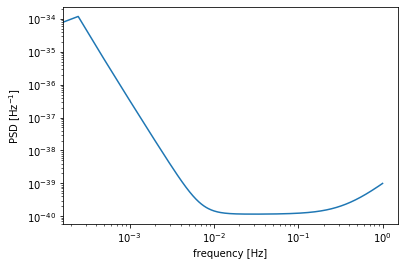

In [3]:
L_TQ = 1.7e8
SaTQ = 1e-30
SxTQ = 1e-24
f_star = 3e8/(2*np.pi*L_TQ)

def Snf(f,f_star,SaTQ,SxTQ,L_TQ):
    if f==0:
        return 0
    else:
        return 10/3*1/L_TQ**2 *(2*(1+np.cos(f/f_star)**2)*SaTQ/(2*np.pi*f)**4*(1+1e-4/f)+SxTQ)*(1+(f/(0.41*3e8/2/L_TQ))**2)

SnfTQ= np.asarray([Snf(f,f_star,SaTQ,SxTQ,L_TQ) for f in freq])
plt.loglog(freq,SnfTQ)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [Hz$^{-1}$]')

## 2. 产生频率域噪声

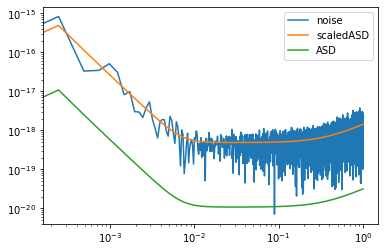

In [4]:
def frequency_noise_from_psd(psd, delta_f, seed=None):
    """ Create noise with a given psd.
    Return noise coloured with the given psd. The returned noise
    FrequencySeries has the same length and frequency step as the given psd.
    Note that if unique noise is desired a unique seed should be provided.
    Parameters
    ----------
    psd : FrequencySeries
        The noise weighting to color the noise.
    seed : {0, int} or None
        The seed to generate the noise. If None specified,
        the seed will not be reset.
    Returns
    --------
    noise : FrequencySeriesSeries
        A FrequencySeries containing gaussian noise colored by the given psd.
    """
    sigma = 0.5 * (psd / delta_f) ** (0.5)
    if seed is not None:
        np.random.seed(seed)

    not_zero = (sigma != 0)

    sigma_red = sigma[not_zero]
    noise_re = np.random.normal(0, sigma_red)
    noise_co = np.random.normal(0, sigma_red)
    noise_red = noise_re + 1j * noise_co

    noise = np.zeros(len(sigma),dtype=complex)
    noise[not_zero] = noise_red

    return noise

noise_f = frequency_noise_from_psd(SnfTQ,delta_f,0)
plt.loglog(freq,np.abs(noise_f),label='noise')
plt.loglog(freq,np.sqrt(SnfTQ/delta_f/2),label='scaledASD')
plt.loglog(freq,np.sqrt(SnfTQ),label='ASD')
plt.legend()

## 3. 产生时间域噪声

Text(0, 0.5, 'strain')

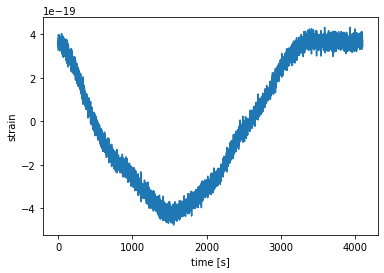

In [5]:
delta_t = 1/(2*f_max)
noise_t = np.fft.irfft(noise_f)/delta_t
times   = np.arange((flen-2)*2+2)*delta_t # 做irFFT时，头尾两个点不动，得到中间的N-2个点的厄米共轭，故有(N-2)*2+2,也就是(N-1)*2个点

plt.plot(times,noise_t)
plt.xlabel('time [s]')
plt.ylabel('strain')

## 4. 验证

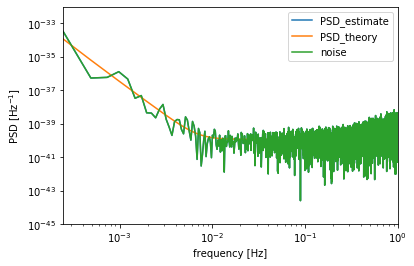

In [6]:
from scipy import signal
fs = 1/delta_t
freqs, psd = signal.periodogram(noise_t,2)
plt.loglog(freqs,psd,label='PSD_estimate')
plt.loglog(freq,SnfTQ,label='PSD_theory')
plt.loglog(freq,np.abs(noise_f**2*delta_f*2),label='noise')
plt.xlim([f_low,f_max])
plt.ylim([1e-45,1e-32])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [Hz$^{-1}$]')
plt.legend()

## 注意，蓝色线和绿色线完全重合，表明结果与预期一致。